In [1]:
import datetime
import functools
import gc
import os
import random
from time import time

import numpy as np
from IPython.display import Markdown, display
from matplotlib import pyplot as plt
from mpl_toolkits import axes_grid1

# INFO messages are not printed.
# This must be run before loading other modules.
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

In [2]:
import tensorflow as tf
import tensorflow_addons as tfa

import tensorflow_datasets as tfds

In [3]:
# install TF similarity if needed
try:
    import tensorflow_similarity as tfsim  # main package
except ModuleNotFoundError:
    !pip install tfsim-nightly
    import tensorflow_similarity as tfsim

Your CPU supports instructions that this binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2
For maximum performance, you can install NMSLIB from sources 
pip install --no-binary :all: nmslib


In [4]:
tfsim.utils.tf_cap_memory()  # Avoid GPU memory blow up

Physical devices cannot be modified after being initialized


In [5]:
# Clear out any old model state.
gc.collect()
tf.keras.backend.clear_session()

In [6]:
ds, data_info = tfds.load("cars196", split="all", with_info=True, as_supervised=True)
# num_examples_train = data_info.splits["train"].num_examples
# num_examples_test = data_info.splits["test"].num_examples
total_num_classes = data_info.features["label"].num_classes

In [8]:
training_classes = total_num_classes // 1
examples_per_class_per_batch = 5

batch_size = 80
classes_per_batch = batch_size // examples_per_class_per_batch  # 16 classes per batch
origin_img_size = 256
target_img_size = 224
area_range = [0.16, 1.0]
# preprocessing function that resizes images to ensure all images are the same shape
pxl_mean = tf.constant(-np.array([0.485, 0.456, 0.406]), dtype=tf.float32)
pxl_std = tf.constant(np.array([0.229, 0.224, 0.225]), dtype=tf.float32)

train_cls = list(range(98))
test_cls = list(range(98, 196))

print(f"Class IDs seen during training {train_cls}")


def preprocess(img, y, *args, origin_size):
    with tf.device("/cpu:0"):
        img = tf.keras.layers.Resizing(origin_size, origin_size, crop_to_aspect_ratio=True)(img)
        # 'RGB'->'BGR'
        img = img[..., ::-1]
        # normalize_transform
        img /= 255.0
        img = tf.nn.bias_add(img, pxl_mean, data_format=None)
        img /= pxl_std

    return img, y


def train_augmentation(img_batch, y, *args, target_size, area_range):
    # create random crops
    num_imgs = tf.shape(img_batch)[0]
    crop_area = tf.random.uniform(shape=(num_imgs, 1), minval=0.15, maxval=1.0)
    start_y = tf.random.uniform(shape=(num_imgs, 1), minval=0.0, maxval=1 - crop_area)
    start_x = tf.random.uniform(shape=(num_imgs, 1), minval=0.0, maxval=1 - crop_area)
    start_yx = tf.concat((start_y, start_x), axis=1)
    end_yx = start_yx + crop_area
    boxes = tf.concat((start_yx, end_yx), axis=1)
    box_indicies = tf.range(num_imgs)

    # random crop
    img_batch = tf.image.crop_and_resize(img_batch, boxes, box_indicies, (target_size, target_size))
    # random horizontal flip
    img_batch = tf.image.random_flip_left_right(img_batch)

    return img_batch, y


def test_augmentation(img_batch, y, *args, origin_size, target_size):
    img_batch = tf.image.central_crop(img_batch, target_size / origin_size)
    img_batch = tf.keras.layers.Resizing(target_size, target_size, crop_to_aspect_ratio=True)(img_batch)

    return img_batch, y


ds = ds.map(lambda x, y: preprocess(x, y, origin_size=origin_img_size))
train_ds = tuple(zip(*tfds.as_numpy(ds.filter(lambda x, y: tf.math.reduce_any(tf.equal(y, train_cls))))))
test_ds = tuple(zip(*tfds.as_numpy(ds.filter(lambda x, y: tf.math.reduce_any(tf.equal(y, test_cls))))))

train_x = train_ds[0]
train_y = train_ds[1]

test_x = test_ds[0]
test_y = test_ds[1]

# use the train split for training
train_ds = tfsim.samplers.MultiShotMemorySampler(
    x=train_x,
    y=train_y,
    examples_per_class_per_batch=examples_per_class_per_batch,
    classes_per_batch=classes_per_batch,
    class_list=train_cls,
    augmenter=functools.partial(
        train_augmentation,
        target_size=target_img_size,
        area_range=area_range,
    ),
)  # We filter train data to only keep the train classes.

# use the test split for indexing and querying
test_ds = tfsim.samplers.MultiShotMemorySampler(
    x=test_x,
    y=test_y,
    examples_per_class_per_batch=examples_per_class_per_batch,
    classes_per_batch=classes_per_batch,
    augmenter=functools.partial(
        test_augmentation,
        origin_size=origin_img_size,
        target_size=target_img_size,
    ),
)


# # use the train split for training
# train_ds = tfsim.samplers.TFDatasetMultiShotMemorySampler(
#     "cars196",
#     splits="all",
#     examples_per_class_per_batch=examples_per_class_per_batch,
#     classes_per_batch=classes_per_batch,
#     preprocess_fn=functools.partial(preprocess, origin_size=origin_img_size),
#     class_list=train_cls,
#     augmenter=functools.partial(
#         train_augmentation,
#         target_size=target_img_size,
#         area_range=area_range,
#     ),
# )  # We filter train data to only keep the train classes.

# # use the test split for indexing and querying
# test_ds = tfsim.samplers.TFDatasetMultiShotMemorySampler(
#     "cars196",
#     splits="all",
#     examples_per_class_per_batch=examples_per_class_per_batch,
#     classes_per_batch=classes_per_batch,
#     preprocess_fn=functools.partial(preprocess, origin_size=origin_img_size),
#     augmenter=functools.partial(
#         test_augmentation,
#         origin_size=origin_img_size,
#         target_size=target_img_size,
#     ),
# )

num_examples_train = len(train_ds._y)
num_examples_test = len(test_ds._y)

Class IDs seen during training [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97]

The initial batch size is 80 (16 classes * 5 examples per class) with 0 augmenters


filtering examples:   0%|          | 0/8054 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/98 [00:00<?, ?it/s]

gather examples:   0%|          | 0/8054 [00:00<?, ?it/s]

indexing classes:   0%|          | 0/8054 [00:00<?, ?it/s]


The initial batch size is 80 (16 classes * 5 examples per class) with 0 augmenters


filtering examples:   0%|          | 0/8131 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/98 [00:00<?, ?it/s]

gather examples:   0%|          | 0/8131 [00:00<?, ?it/s]

indexing classes:   0%|          | 0/8131 [00:00<?, ?it/s]

2022-04-26 03:23:44.545518: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 6333923328 exceeds 10% of free system memory.
2022-04-26 03:23:48.191098: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 6333923328 exceeds 10% of free system memory.
2022-04-26 03:23:51.837322: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 6333923328 exceeds 10% of free system memory.


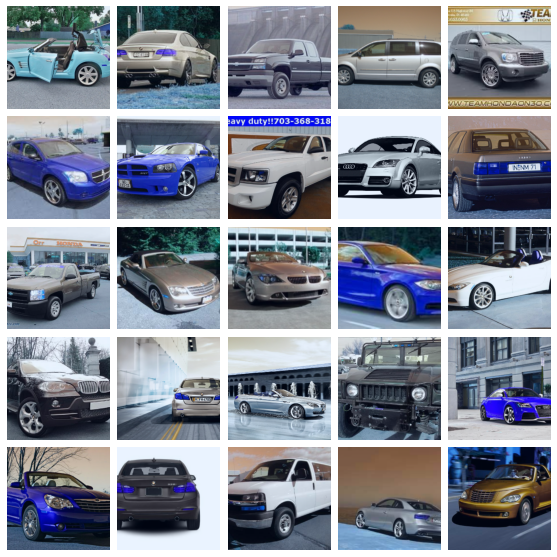

In [9]:
num_cols = num_rows = 5
# Get the first 25 examples.
x_slice, y_slice = train_ds.get_slice(begin=0, size=num_cols * num_rows)

x_min = tf.math.reduce_min(x_slice)
x_max = tf.math.reduce_max(x_slice)

fig = plt.figure(figsize=(10.0, 10.0))
grid = axes_grid1.ImageGrid(fig, 111, nrows_ncols=(num_cols, num_rows), axes_pad=0.1)

# NOTE: the colors will be off because the resnet preprocessing rotates the color channels.
for ax, im, label in zip(grid, (x_slice - x_min) / (x_max - x_min), y_slice):
    ax.imshow(im)
    ax.axis("off")

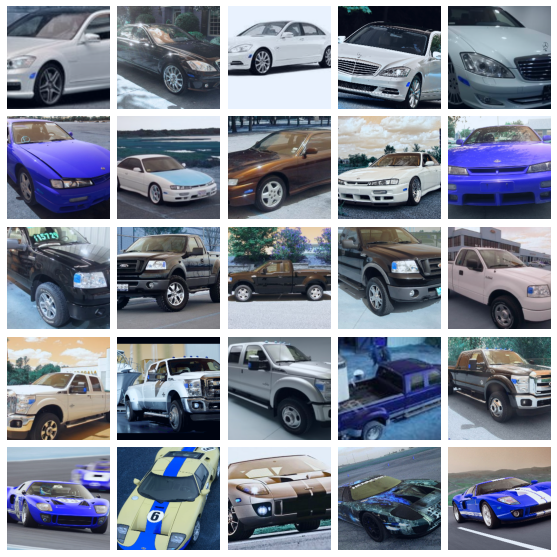

In [10]:
num_cols = num_rows = 5
# Get the first 25 examples.
(x_batch, y_batch) = test_ds.generate_batch(0)
x_slice = x_batch[0 : num_cols * num_rows]
y_slice = y_batch[0 : num_cols * num_rows]

x_min = tf.math.reduce_min(x_slice)
x_max = tf.math.reduce_max(x_slice)

fig = plt.figure(figsize=(10.0, 10.0))
grid = axes_grid1.ImageGrid(fig, 111, nrows_ncols=(num_cols, num_rows), axes_pad=0.1)

# NOTE: the colors will be off because the resnet preprocessing rotates the color channels.
for ax, im, label in zip(grid, (x_slice - x_min) / (x_max - x_min), y_slice):
    ax.imshow(im)
    ax.axis("off")

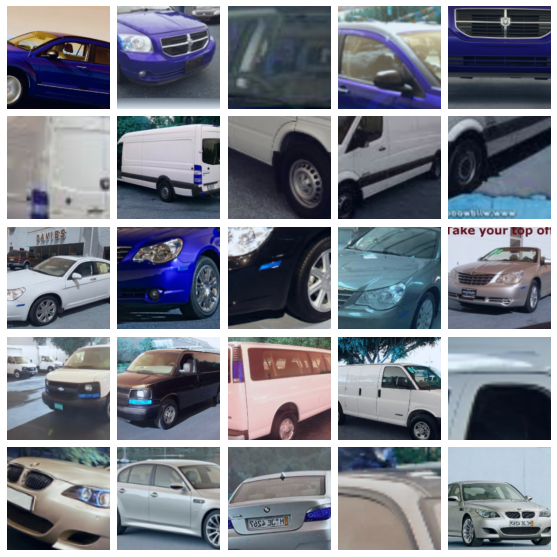

In [11]:
num_cols = num_rows = 5
# Get the first 25 examples.
(x_batch, y_batch) = train_ds.generate_batch(0)
x_slice = x_batch[0 : num_cols * num_rows]
y_slice = y_batch[0 : num_cols * num_rows]

x_min = tf.math.reduce_min(x_slice)
x_max = tf.math.reduce_max(x_slice)

fig = plt.figure(figsize=(10.0, 10.0))
grid = axes_grid1.ImageGrid(fig, 111, nrows_ncols=(num_cols, num_rows), axes_pad=0.1)

# NOTE: the colors will be off because the resnet preprocessing rotates the color channels.
for ax, im, label in zip(grid, (x_slice - x_min) / (x_max - x_min), y_slice):
    ax.imshow(im)
    ax.axis("off")

In [12]:
def generate_eval_data(test_ds, num_queries_per_class, num_index_per_class, class_list):
    q_x, q_y = [], []
    i_x, i_y = [], []

    # get example for each class
    q_idxs = []
    i_idxs = []
    total_samples = num_queries_per_class + num_index_per_class
    for class_id in class_list:
        class_idxs = test_ds.index_per_class[class_id]
        if len(class_idxs) < total_samples:
            print(
                f"warning: Class {class_id} only has {len(class_idxs)} examples but "
                f"{total_samples} were requested. Using choices instead of sample."
            )
            sampled_idxs = random.choices(class_idxs, k=total_samples)
        else:
            sampled_idxs = random.sample(class_idxs, k=total_samples)

        q_idxs.extend(sampled_idxs[:num_queries_per_class])
        i_idxs.extend(sampled_idxs[num_queries_per_class:])

    # strip examples if needed. This might happen due to rounding
    for idx in q_idxs:
        q_x.append(test_ds._x[idx])
        q_y.append(test_ds._y[idx])

    for idx in i_idxs:
        i_x.append(test_ds._x[idx])
        i_y.append(test_ds._y[idx])

    return (
        tf.convert_to_tensor(np.array(q_x)),
        tf.convert_to_tensor(np.array(q_y)),
        tf.convert_to_tensor(np.array(i_x)),
        tf.convert_to_tensor(np.array(i_y)),
    )

In [13]:
num_queries_per_class = 3
num_index_per_class = 10
k = 1

# Setup EvalCallback by splitting the test data into targets and queries.
queries_x, queries_y, targets_x, targets_y = generate_eval_data(test_ds, num_queries_per_class, num_index_per_class, test_cls)

queries_x, queries_y = test_augmentation(
    queries_x,
    queries_y,
    origin_size=origin_img_size,
    target_size=target_img_size,
)
targets_x, targets_y = test_augmentation(
    targets_x,
    targets_y,
    origin_size=origin_img_size,
    target_size=target_img_size,
)

# Setup SplitValidation callback.
val_loss = tfsim.callbacks.EvalCallback(
    queries_x,
    tf.cast(queries_y, dtype=tf.dtypes.int32),
    targets_x,
    tf.cast(targets_y, dtype=tf.dtypes.int32),
    metrics=["f1", "binary_accuracy"],
    # known_classes=tf.constant(train_cls),
    k=k,
)

logdir = os.path.join("logs_cars", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
print(logdir)
tbc = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

callbacks = [
    val_loss,
    tbc,
]

logs_cars/20220426-032626


In [14]:
embedding_size = 512

# building model
model = tfsim.architectures.ResNet50Sim(
    (target_img_size, target_img_size, 3),
    embedding_size,
    trainable="full",
    pooling="avg",  # Can change to use `gem` -> GeneralizedMeanPooling2D
    # gem_p=3.0,        # Increase the contrast between activations in the feature map.
)

In [15]:
epochs = 1500
LR = 0.00003
WD = 0.0005
steps_per_epoch = num_examples_train // batch_size
validation_steps = num_examples_test // batch_size
val_steps = 50


# init similarity loss
distance = "cosine"
loss = tfsim.losses.MultiSimilarityLoss(distance=distance, alpha=2.0, beta=50.0, epsilon=0.1, lmda=1.0, center=1.0)
# optimizer = tfa.optimizers.AdamW(
#     weight_decay=WD,
#     learning_rate=LR
# )
optimizer = tf.keras.optimizers.Adam(LR)


# compiling and training
model.compile(optimizer=optimizer, loss=loss)

Distance metric automatically set to cosine use the distance arg to override.


In [ ]:
history = model.fit(
    train_ds,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_ds,
    validation_steps=validation_steps,
    callbacks=callbacks,
)

/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/1500
  6/100 [>.............................] - ETA: 40s - loss: 1.2701WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1795s vs `on_train_batch_end` time: 0.2259s). Check your callbacks.


100/100 [==============================] - ETA: 0s - loss: 0.9513Warmup complete
f1: 0.0909 - binary_accuracy: 0.0476
100/100 [==============================] - 79s 677ms/step - loss: 0.9513 - val_loss: 0.8872 - f1: 0.0909 - binary_accuracy: 0.0476
Warmup complete
Epoch 2/1500
100/100 [==============================] - 65s 652ms/step - loss: 0.8824 - val_loss: 0.8857 - f1: 0.0909 - binary_accuracy: 0.0476
Epoch 3/1500
100/100 [==============================] - 65s 653ms/step - loss: 0.8797 - val_loss: 0.8830 - f1: 0.1625 - binary_accuracy: 0.0884
Epoch 4/1500
100/100 [==============================] - 65s 651ms/step - loss: 0.8777 - val_loss: 0.8780 - f1: 0.2655 - binary_accuracy: 0.1531
Epoch 5/1500
100/100 [==============================] - 65s 651ms/step - loss: 0.8757 - val_loss: 0.8727 - f1: 0.3802 - binary_accuracy: 0.2347
Epoch 6/1500
100/100 [==============================] - 65s 652ms/step - loss: 0.8740 - val_loss: 0.8695 - f1: 0.4320 - binary_accuracy: 0.2755
Epoch 7/1500
10

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["loss", "val_loss"])
plt.title(f"Loss: {loss.name} - LR: {LR}")
plt.show()

In [ ]:
num_queries_per_class = 10
num_index_per_class = 30

# Setup EvalCallback by splitting the test data into targets and queries.
queries_x, queries_y, targets_x, targets_y = generate_eval_data(test_ds, num_queries_per_class, num_index_per_class, test_cls)

queries_x, queries_y = test_augmentation(
    queries_x,
    queries_y,
    origin_size=origin_img_size,
    target_size=target_img_size,
)
targets_x, targets_y = test_augmentation(
    targets_x,
    targets_y,
    origin_size=origin_img_size,
    target_size=target_img_size,
)


model.reset_index()
model.index(targets_x, index_y)

In [ ]:
calibration_results = model.calibrate(queries_x, queries_y)

In [ ]:
recall_metrics = [tfsim.retrieval_metrics.RecallAtK(k=i) for i in (1, 5, 10, 20, 50)]
prec_metrics = [tfsim.retrieval_metrics.PrecisionAtK(k=i) for i in (1, 5, 10, 20, 50)]
dist_thresh = np.round(calibration_results.cutpoints["optimal"]["distance"], 4)
bndcg_metrics = [tfsim.retrieval_metrics.BNDCG(k=i, distance_threshold=dist_thresh) for i in (1, 5, 10, 20, 50)]

model.evaluate_retrieval(queries_x, queries_y, recall_metrics + prec_metrics + bndcg_metrics);